<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/MLP_Mixer_Deep_Course_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



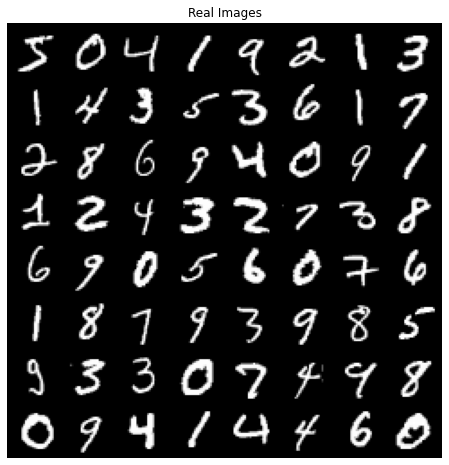

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)
  
  def forward(self, x):
    x = self.projection(x)
    B, C, H, W = x.shape
    # print(W, H)
    # reshape to (Batch size, nb tokens, embedding)
    x = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
    return x

In [6]:
PatchEmbed()(torch.randn(16, 1, 32, 32)).shape

torch.Size([16, 16, 128])

In [7]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(in_features, hid_features),
        nn.GELU(),
        nn.Linear(hid_features, in_features),
        nn.GELU()
    )

  def forward(self, x):
    return self.mlp(x)

In [8]:
MLP(5, 20)(torch.randn(3, 16, 5)).shape

torch.Size([3, 16, 5])

In [9]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/block.py
%pycat block.py

--2023-03-13 15:02:19--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/block.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 779 [text/plain]
Saving to: ‘block.py’

block.py            100%[===================>]     779  --.-KB/s    in 0s      

2023-03-13 15:02:19 (51.5 MB/s) - ‘block.py’ saved [779/779]



In [10]:
class Mixer(nn.Module):
  def __init__(self, embed_dim, nb_patches, mlp_ratio=(0.5, 4.0)):
    super().__init__()

    tokens_dim = int(mlp_ratio[0] * nb_patches)
    channels_dim = int(mlp_ratio[1] * embed_dim)
    
    self.layer_norm_1 = nn.LayerNorm(embed_dim)
    self.layer_norm_2 = nn.LayerNorm(embed_dim)

    self.mlp_mixer_tokens = MLP(nb_patches, tokens_dim)
    self.mlp_mixer_channels = MLP(embed_dim, channels_dim)

  def forward(self, x):
    x = self.layer_norm_1(x) # B, P, C
    
    transposed_patch = torch.transpose(x, 1, 2) # B, C, P
    #print(transposed_patch.shape)
    transformed_patch = self.mlp_mixer_tokens(transposed_patch) # B, C, P_
    #print(transformed_patch.shape)

    x = x + torch.transpose(transformed_patch, 1, 2) # B, P_, C + B, P, C = B, Q, C
    #print(x.shape)
          
    x = self.layer_norm_2(x) # B, Q, C
    #print(x.shape)

    x = x + self.mlp_mixer_channels(x) # B, Q, C + B, Q, C_ = B, Q, T
    #print(x.shape)
    return x

In [11]:
Mixer(6, 4)(torch.randn(2, 4, 6)).shape

torch.Size([2, 4, 6])

In [ ]:
class ResMLPMixer(self, embed_dim,)

In [21]:
class MLPMixer(nn.Module):
  def __init__(self, embed_dim, nb_mlp_blocks, patch_size, nb_classes=10):
    super().__init__()

    self.nb_patches = (28 // patch_size) ** 2
    self.patch_embedding_layer = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)
    self.layer_norm = nn.LayerNorm(embed_dim)
    self.full_connected = nn.Linear(embed_dim, nb_classes)

    blocks = [Mixer(embed_dim, self.nb_patches) for _ in range(nb_mlp_blocks)]
    self.mlp_mixer = nn.Sequential(*blocks)

  def forward(self, x):
    x = self.patch_embedding_layer(x)
    x = self.mlp_mixer(x)
    x = self.layer_norm(x)
    #print(x.shape)
    x = x.mean(dim=1)
    #print('after global pooling along patch axis', x.shape)
    x = self.full_connected(x)
    return x


In [29]:
@torch.no_grad()

def eval_model(model, loader):
  model.eval()
  acc = 0.
  count = 0

  for x,y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    count += len(x)
  
  model.train()
  return round(100 * (acc / count), 2)

In [30]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = MLPMixer(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
  train_loss = 0.
  for x,y in train_loader:
    x,y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    # print(yhat[0])
    # print('original: ', y[0])
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()
    
    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.9176076098736415
--- Epoch 1 ---
Train loss: 0.2478062914950507
--- Epoch 2 ---
Train loss: 0.18155834933858056
--- Epoch 3 ---
Train loss: 0.1483693081420908
--- Epoch 4 ---
Train loss: 0.12668956457170596
--- Epoch 5 ---
Train loss: 0.11049002693541078
--- Epoch 6 ---
Train loss: 0.09787152967910205
--- Epoch 7 ---
Train loss: 0.08783634504907008
--- Epoch 8 ---
Train loss: 0.07960099148065615
--- Epoch 9 ---
Train loss: 0.07277282756338241
Test accuracy: 96.29


In [15]:
MLPMixer(6, 3, 7)(torch.randn(16, 1, 32, 32)).shape

torch.Size([16, 16, 6])
after global pooling along patch axis torch.Size([16, 6])


torch.Size([16, 10])

In [16]:
x = torch.randn(3,4)
print(x)

print(x.shape)

x = torch.transpose(x, 0, 1)
print(x)
print(x.shape)

tensor([[ 1.2090,  0.1075,  0.4471,  0.0338],
        [-1.5893,  0.6959,  1.5831,  1.5305],
        [-1.4260, -0.6905,  1.1157,  0.4667]])
torch.Size([3, 4])
tensor([[ 1.2090, -1.5893, -1.4260],
        [ 0.1075,  0.6959, -0.6905],
        [ 0.4471,  1.5831,  1.1157],
        [ 0.0338,  1.5305,  0.4667]])
torch.Size([4, 3])


In [17]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/mixer.py
%pycat mixer.py

--2023-03-13 15:02:25--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/mixer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 670 [text/plain]
Saving to: ‘mixer.py’

mixer.py            100%[===================>]     670  --.-KB/s    in 0s      

2023-03-13 15:02:25 (33.8 MB/s) - ‘mixer.py’ saved [670/670]

